In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Input , BatchNormalization , Dropout
from keras.callbacks import EarlyStopping
from statsmodels.tsa.arima.model import ARIMA
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split

2024-10-09 07:51:53.333348: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-09 07:51:53.362937: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-09 07:51:53.367230: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-09 07:51:53.381439: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-09 07:51:54.899197: W tensorflow/compiler/tf2

In [2]:
# Load the CSV file
file_path = '/workspaces/pharmacymlproject/Medical Inventory Optimization Dataset - Cleaned.csv'
data = pd.read_csv(file_path)

In [3]:
# Convert Dateofbill to datetime
data['Dateofbill'] = pd.to_datetime(data['Dateofbill'])
# Create a dictionary for DrugName to category code
drugname_to_catcode = dict(enumerate(data['DrugName'].astype('category').cat.categories))
# Step 2: Create a reverse mapping dictionary
catcode_to_drugname = {v: k for k, v in drugname_to_catcode.items()}

# Step 3: Update the data['DrugName'] column using the reverse mapping
data['DrugName'] = data['DrugName'].map(catcode_to_drugname)

# Aggregate Quantity and Final_Sales by DrugName, Dateofbill, and Dept
aggregated_data = data.groupby(['DrugName', 'Dateofbill']).agg({
    'Quantity': 'sum',
    'Final_Sales': 'sum'
}).reset_index()

# Add DrugName to aggregated data
aggregated_data = pd.merge(aggregated_data, data[['DrugName', 'Dateofbill']].drop_duplicates(), on=['DrugName', 'Dateofbill'], how='left')

In [4]:
# Feature Engineering
# Extract date features
aggregated_data['Is_Weekend'] = aggregated_data['Dateofbill'].dt.dayofweek >= 5

# Lag features for Quantity and Final_Sales
aggregated_data['Lag_7'] = aggregated_data.groupby('DrugName')['Final_Sales'].shift(7)
aggregated_data['Lag_14'] = aggregated_data.groupby('DrugName')['Final_Sales'].shift(14)
aggregated_data['Lag_30'] = aggregated_data.groupby('DrugName')['Final_Sales'].shift(30)


In [5]:
# Calculate rolling averages for Quantity and Final_Sales
aggregated_data['Quantity_MA'] = aggregated_data.groupby('DrugName')['Quantity'].transform(lambda x: x.rolling(window=7, min_periods=1).mean())
aggregated_data['Final_Sales_MA'] = aggregated_data.groupby('DrugName')['Final_Sales'].transform(lambda x: x.rolling(window=7, min_periods=1).mean())

# Drop NaN values after creating lag features
aggregated_data.dropna(inplace=True)

aggregated_data = aggregated_data.sort_values(by='Dateofbill')



# Prepare data for modeling
X = aggregated_data[['DrugName','Is_Weekend', 'Lag_7','Lag_14','Lag_30', 'Quantity_MA', 'Final_Sales_MA']]
y = aggregated_data['Final_Sales']

# Split data into training and testing sets using TimeSeriesSplit for cross-validation
tscv = TimeSeriesSplit(n_splits=3)


In [6]:
# Output the aggregated data to a CSV file
aggregated_data.to_csv('aggregated_data.csv', index=False)

In [7]:
# Initialize Ridge Regression model and hyperparameter grid
ridge_model = Ridge()
param_grid = {'alpha': [0.1, 1.0, 10.0, 100.0]}
grid_search = GridSearchCV(ridge_model, param_grid, cv=5, scoring='neg_mean_squared_error')

# List to store RMSE for each split
rmse_list = []

# Perform time series cross-validation
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Fit GridSearchCV
    grid_search.fit(X_train, y_train)

    # Best model
    ridge_model = grid_search.best_estimator_
    predictions = ridge_model.predict(X_test)
    rmse = mean_squared_error(y_test, predictions, squared=False)
    rmse_list.append(rmse)

# Calculate average RMSE
ridge_rmse = np.mean(rmse_list)
ridge_rmse

/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


374.445651189261

In [8]:
# Initialize Random Forest model and hyperparameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20],
    'max_features': ['sqrt', 'log2']
}
grid_search = GridSearchCV(RandomForestRegressor(), param_grid, cv=tscv, scoring='neg_mean_squared_error')

# List to store RMSE for each split
rmse_list = []

# Perform time series cross-validation
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Fit GridSearchCV
    grid_search.fit(X_train, y_train)

    # Best model
    best_rf_model = grid_search.best_estimator_
    rf_predictions = best_rf_model.predict(X_test)
    rf_rmse = mean_squared_error(y_test, rf_predictions, squared=False)
    rmse_list.append(rf_rmse)

# Calculate average RMSE
rf_rmse = np.mean(rmse_list)
rf_rmse

/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


395.41588371921256

In [9]:
# 3. LSTM Model
lstm_rmse_list = []

for train_index, test_index in tscv.split(X):
    X_train2, X_test2 = X.iloc[train_index], X.iloc[test_index]
    y_train2, y_test2 = y.iloc[train_index], y.iloc[test_index]

    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)
    X_train_scaled, X_test_scaled = X_scaled[train_index], X_scaled[test_index]

    window_size = 7
    X_train_lstm = np.array([X_train_scaled[i-window_size:i] for i in range(window_size, len(X_train_scaled))])
    y_train_lstm = y_train2.iloc[window_size:].values
    X_test_lstm = np.array([X_test_scaled[i-window_size:i] for i in range(window_size, len(X_test_scaled))])
    y_test_lstm = y_test2.iloc[window_size:].values

    lstm_model = Sequential()
    lstm_model.add(Input(shape=(window_size, X_train_scaled.shape[1])))
    lstm_model.add(LSTM(100, return_sequences=True))
    lstm_model.add(BatchNormalization())
    lstm_model.add(Dropout(0.2))
    lstm_model.add(LSTM(100))
    lstm_model.add(BatchNormalization())
    lstm_model.add(Dropout(0.2))
    lstm_model.add(Dense(1))
    lstm_model.compile(optimizer='adam', loss='mean_squared_error')

    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    lstm_model.fit(X_train_lstm, y_train_lstm, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping])
    lstm_predictions = lstm_model.predict(X_test_lstm)
    lstm_rmse = mean_squared_error(y_test_lstm, lstm_predictions, squared=False)
    lstm_rmse_list.append(lstm_rmse)



Epoch 1/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 392432.0000 - val_loss: 365706.3125
Epoch 2/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 355529.2812 - val_loss: 365522.3125
Epoch 3/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 463941.5625 - val_loss: 365401.8125
Epoch 4/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 396615.2500 - val_loss: 365499.2812
Epoch 5/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 477453.5938 - val_loss: 365465.3750
Epoch 6/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 464730.5625 - val_loss: 365780.6250
Epoch 7/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 373959.8438 - val_loss: 365234.7500
Epoch 8/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 343635.7812 - val_loss: 365311.6875
Epoch 9/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 416546.6562 - val_loss: 365018.1875
Epoch 10/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 311935.5625 - val_loss: 365136.3750
Epoch 11/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss:

/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 579231.0000 - val_loss: 361785.3750
Epoch 2/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 354499.9062 - val_loss: 361056.8125
Epoch 3/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 413811.5000 - val_loss: 360169.5312
Epoch 4/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 414539.7500 - val_loss: 358028.3750
Epoch 5/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 434605.7812 - val_loss: 355797.7188
Epoch 6/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 414010.6875 - val_loss: 352474.7812
Epoch 7/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 469979.3125 - val_loss: 348160.1562
Epoch 8/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 376796.4688 - val_loss: 346424.3438
Epoch 9/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 421404.6875 - val_loss: 342293.6562
Epoch 10/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 419500.0312 - val_loss: 338690.3438
Epoch 11/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 418631.593

/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


84/84 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 353224.5625 - val_loss: 360195.5312
Epoch 2/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 422363.5312 - val_loss: 357923.1875
Epoch 3/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 350360.2188 - val_loss: 355757.3750
Epoch 4/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 370009.2188 - val_loss: 350240.2500
Epoch 5/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 463166.2812 - val_loss: 346941.4062
Epoch 6/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 405368.9688 - val_loss: 333355.8438
Epoch 7/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 367956.0938 - val_loss: 345823.5312
Epoch 8/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 300900.7812 - val_loss: 342438.8125
Epoch 9/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 423275.9062 - val_loss: 336458.3438
Epoch 10/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 367134.3750 - val_loss: 323208.9375
Epoch 11/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 316534.875

/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [10]:
lstm_rmse_list = np.mean(lstm_rmse_list)
rf_rmse

395.41588371921256

In [11]:
# 4. Stacking Regressor (Combining Ridge and Random Forest)
# List to store RMSE for each split
rmse_list = []

# Perform time series cross-validation
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Initialize and fit Stacking Regressor
    estimators = [
        ('rf', best_rf_model),
        ('ridge', ridge_model)
    ]
    stacking_model = StackingRegressor(estimators=estimators, final_estimator=LinearRegression())
    stacking_model.fit(X_train, y_train)

    # Make predictions and calculate RMSE
    stacking_predictions = stacking_model.predict(X_test)
    stacking_rmse = mean_squared_error(y_test, stacking_predictions, squared=False)
    rmse_list.append(stacking_rmse)

# Calculate average RMSE
stacking_rmse = np.mean(rmse_list)
stacking_rmse

/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


376.5908482153106

In [12]:

# Print RMSE for each model
print(f'Ridge Regression RMSE: {ridge_rmse}')
print(f'Random Forest RMSE (with hyperparameter tuning): {rf_rmse}')
print(f'LSTM RMSE: {np.min(lstm_rmse_list)}')
print(f'Stacking Regressor RMSE: {stacking_rmse}')

Ridge Regression RMSE: 374.445651189261
Random Forest RMSE (with hyperparameter tuning): 395.41588371921256
LSTM RMSE: 616.4032934608981
Stacking Regressor RMSE: 376.5908482153106


In [13]:
# Calculate last known moving averages and lag for future predictions
last_known_date = aggregated_data['Dateofbill'].max()
last_known_quantity_ma = aggregated_data.loc[aggregated_data['Dateofbill'] == last_known_date, 'Quantity_MA'].values[0]
last_known_final_sales_ma = aggregated_data.loc[aggregated_data['Dateofbill'] == last_known_date, 'Final_Sales_MA'].values[0]
last_known_lag_7 = aggregated_data.loc[aggregated_data['Dateofbill'] == last_known_date, 'Lag_7'].values[0]
last_known_lag_14 = aggregated_data.loc[aggregated_data['Dateofbill'] == last_known_date, 'Lag_14'].values[0]
last_known_lag_30 = aggregated_data.loc[aggregated_data['Dateofbill'] == last_known_date, 'Lag_30'].values[0]



In [14]:
# Predict future sales using the best model (e.g., Stacking)
future_dates = pd.date_range(start=last_known_date, periods=7, freq='D')
# Assuming 'data' is your original DataFrame containing the 'DrugName' column
unique_drug_names = data['DrugName'].unique()

# Initialize an empty list to store DataFrames
future_data_list = []

# Iterate over each unique drug name
for drug_name in unique_drug_names:
    # Create a DataFrame for each drug name
    future_data_drug = pd.DataFrame({
        'Dateofbill': future_dates,
        'DrugName': drug_name, 
        'Is_Weekend': future_dates.dayofweek >= 5,
        'Lag_7': last_known_lag_7,
        'Lag_14': last_known_lag_14,
        'Lag_30': last_known_lag_30,
        'Quantity_MA': last_known_quantity_ma,
        'Final_Sales_MA': last_known_final_sales_ma
    })
    # Append the DataFrame to the list
    future_data_list.append(future_data_drug)

# Concatenate all DataFrames into a single DataFrame
future_data = pd.concat(future_data_list, ignore_index=True)

future_data.to_csv('future_data.csv', index=False)

In [15]:
# Select relevant columns and drop rows with missing values
future_X = future_data[['DrugName', 'Is_Weekend', 'Lag_7', 'Lag_14', 'Lag_30', 'Quantity_MA', 'Final_Sales_MA']].dropna()


# Make predictions using the stacking model
future_predictions = stacking_model.predict(future_X)

# Display future predictions and optimal stock levels
future_data.loc[future_X.index, 'Predicted_Sales'] = future_predictions

# Convert DrugName to categorical codes if necessary
future_data['DrugName'] = future_data['DrugName'].map(drugname_to_catcode)

In [16]:
# Sort the future_data DataFrame by Dateofbill
future_data_sorted = future_data.sort_values(by='Dateofbill')

# Display the sorted future_data DataFrame
print(future_data_sorted[['Dateofbill', 'DrugName', 'Predicted_Sales']])

result = future_data_sorted[['Dateofbill','DrugName','Predicted_Sales']]
result.to_csv('future_predictions.csv', index=False)




     Dateofbill                      DrugName  Predicted_Sales
0    2022-12-31     ZINC ACETATE 20MG/5ML SYP       258.850511
1736 2022-12-31              CLONAZEPAM 0.5MG       264.590187
1729 2022-12-31     XYLOMETAZOLINE 10ML DROPS       258.856358
1722 2022-12-31      OCTREOTIDE 50MCG 1ML INJ       260.639107
1715 2022-12-31           LIPID 20% 100ML TPN       264.126200
...         ...                           ...              ...
3051 2023-01-06  FORTIFIED BABY CEREAL POWDER       262.366589
3044 2023-01-06           ISAVUCONAZOLE 200MG       261.780211
3037 2023-01-06       LEVETIRACETAM 500MG TAB       261.821835
3023 2023-01-06             ZOLPIDEM 10MG TAB       256.553584
5263 2023-01-06           FENTANYL 12.5MCG/HR       262.341427

[5264 rows x 3 columns]


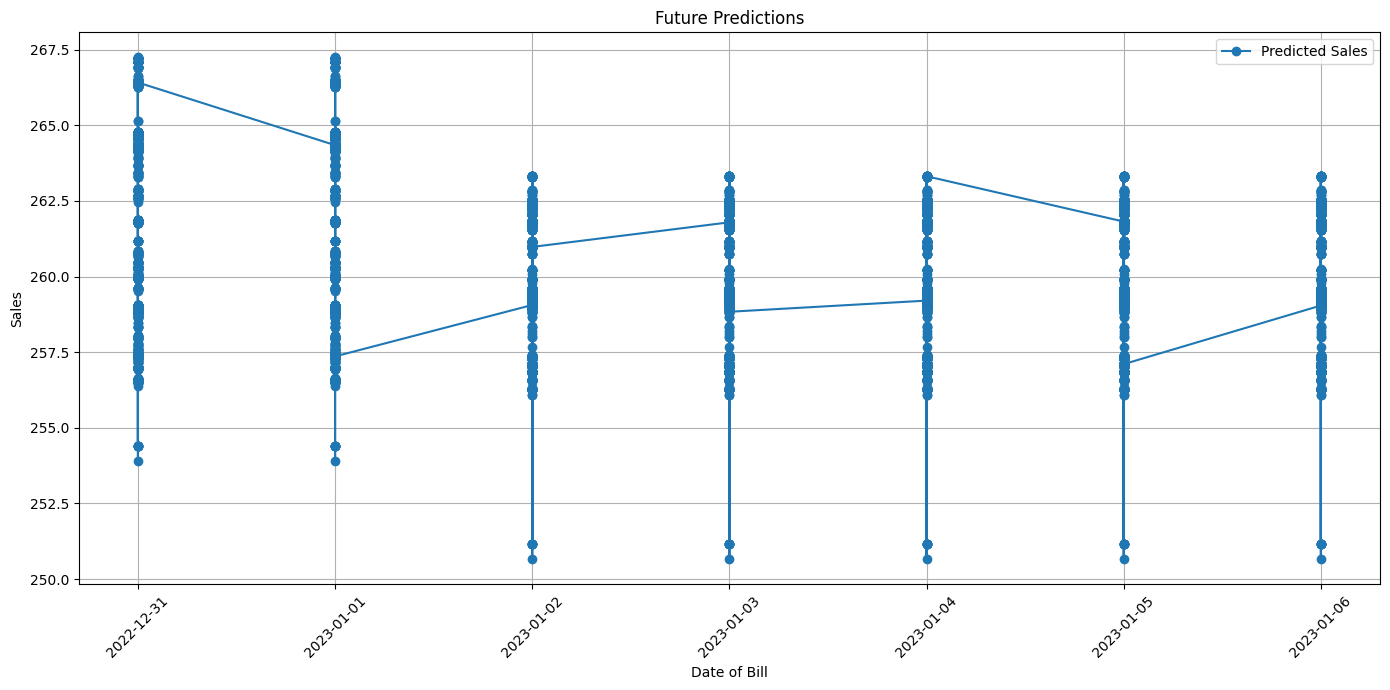

In [20]:
import matplotlib.pyplot as plt

# Assuming future_data_sorted is already sorted by Dateofbill

# Plot future predictions
plt.figure(figsize=(14, 7))
plt.plot(future_data_sorted['Dateofbill'], future_data_sorted['Predicted_Sales'], label='Predicted Sales', marker='o')

# Customize the plot
plt.xlabel('Date of Bill')
plt.ylabel('Sales')
plt.title('Future Predictions')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# Display the plot
plt.show()